> Purpose

Produce graphics that show audience about the tropical cyclones (TC) risk for PH. With a focus on TC induced rainfall, rapid intensification, storm surge, and the change in future climate.


> Data source

Track

IBTRACS

https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r01/access/shapefile/IBTrACS.WP.list.v04r01.lines.zip

https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r01/access/shapefile/IBTrACS.WP.list.v04r01.points.zip

# **Annual count of impacting TCs that experienced rapid intensification. Definition: Maximum sustained wind speed increases by at least 30knots (35mph) within a 24-hour period.**

# **Step 0: Import the Library**


In [1]:
import geopandas as gpd
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np

# **Step 1: Load the Data**

In [2]:
ibtracs_points = gpd.read_file("IBTrACS.WP.list.v04r01.points.shp")
buffer_gdf = gpd.read_file("PHL_1degree_buffer.shp")
lines = gpd.read_file("IBTrACS.WP.list.v04r01.lines.shp")
phl_land = gpd.read_file("PHL_adm0.shp")

# **Step 2: Convert the time to datetime object for later calculaion**

In [3]:
ibtracs_points['ISO_TIME'] = pd.to_datetime(ibtracs_points['ISO_TIME'])

# **Step 3: Aligns to CRS**

Ensure both GeoDataFrames use the same coordinate reference system (CRS), IBTrACS typically uses EPSG:4326 (WGS84)

In [4]:
if ibtracs_points.crs != buffer_gdf.crs:
    buffer_gdf = buffer_gdf.to_crs(ibtracs_points.crs)


# **Step 4: Ensure variable is GeoDataFrame**

Why This Line is Needed
When you load a shapefile using gpd.read_file(points_shapefile), geopandas typically creates a GeoDataFrame with a geometry column containing the spatial data (e.g., point coordinates for TC locations in IBTrACS).

However, in some cases, the loaded object might not be properly initialized as a GeoDataFrame, or the geometry column might not be correctly set or named (e.g., due to shapefile inconsistencies or manual data manipulation).

This line explicitly converts gdf to a GeoDataFrame and designates the column named 'geometry' as the active geometry column, ensuring that geopandas can perform spatial operations like gdf.geometry.within(buffer_gdf.unary_union).

In [5]:
ibtracs_points = gpd.GeoDataFrame(ibtracs_points, geometry='geometry')

# **Step 5: Find the points in the buffer of Philippines**

*   union_all() is a geopandas method that combines all geometries in buffer_gdf’s geometry column into a single shapely geometry

*   .within() checks if each point lies inside the combined buffer geometry (buffer_gdf.union_all()).
It returns a boolean Series (True for points inside the buffer, False for points outside).

*   Finally, filters ibtracs_points to keep only rows where the TC point is within the 1-degree buffer.



In [6]:
gdf_philippines = ibtracs_points[ibtracs_points.geometry.within(buffer_gdf.union_all())]

# **Step 6: Extracts the unique storm identifiers (SIDs) for tropical cyclones that have at least one point within the 1-degree buffer around the Philippines**

*   .unique() method, applied to the SID Series, returns a NumPy array of unique storm IDs, eliminating duplicates.



In [7]:
philippines_sids = gdf_philippines['SID'].unique()


# **Step 7: Keep only rows where the SID is in philippines_sids**

In [8]:
gdf_philippines_storms = ibtracs_points[ibtracs_points['SID'].isin(philippines_sids)]


# **Step 8: converts into a pandas datetime64 type**

In [9]:
gdf_philippines_storms['ISO_TIME'] = pd.to_datetime(gdf_philippines_storms['ISO_TIME'])


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


# **Step 9: identifies instances of rapid intensification (RI) in tropical cyclones (TCs) from a dataset**

Input:

*   df: GeoDataFrame
*   wind_col='WMO_WIND': Column name for wind speed in knots
*   time_col='ISO_TIME': Column name for timestamps
*   threshold=30: Minimum wind speed increase in knots for RI
*   hours=24: Time window in hours bto check for RI

Output:

*   pandas DataFrame listing RI events, with columns SID, start_time, end_time, wind_increase, and year






In [10]:
def detect_rapid_intensification(df, wind_col='USA_WIND', time_col='ISO_TIME', threshold=30, hours=24):
    # Initialize Empty List for RI Events
    ri_events = []
    # Loop Over Unique Storms
    for sid in df['SID'].unique():
        storm_df = df[df['SID'] == sid].sort_values(time_col) # Filters df to include only rows for the current storm (sid)
        storm_df = storm_df.dropna(subset=[wind_col])  # Drop rows with missing wind data
        if len(storm_df) < 2: # Skip Storms with Insufficient Data
            continue
        # Iterate through each point and check subsequent points within 24 hours
        for i in range(len(storm_df)):
            current_time = storm_df.iloc[i][time_col]
            current_wind = storm_df.iloc[i][wind_col]
            # Look ahead within 24 hours
            future_time_limit = current_time + timedelta(hours=hours)
            future_points = storm_df[
                (storm_df[time_col] > current_time) &
                (storm_df[time_col] <= future_time_limit)
            ]
            # Check for RI in Future Points
            for _, future_point in future_points.iterrows():
                wind_diff = future_point[wind_col] - current_wind
                time_diff = (future_point[time_col] - current_time).total_seconds() / 3600 # difference in hour
                if time_diff <= hours and wind_diff >= threshold:
                    ri_events.append({
                        'SID': sid,
                        'start_time': current_time,
                        'end_time': future_point[time_col],
                        'wind_increase': wind_diff,
                        'year': current_time.year
                    })
                    break  # Only count the first RI event per storm to avoid double-counting
    return pd.DataFrame(ri_events)


In [11]:
ri_df = detect_rapid_intensification(gdf_philippines_storms)


# **Step 10: count RI events per year**

In [12]:
if not ri_df.empty: # checks if ri_df has at least one row (i.e., at least one RI event was found)
    # Groups the rows of ri_df by the year column
    # Counts the number of rows (RI events) in each group
    # Converts the Series to a DataFrame with two columns: year: The years from the index. + ri_count: The count of RI events for each year.
    annual_ri_counts = ri_df.groupby('year').size().reset_index(name='ri_count')
else:
    print("No rapid intensification events detected.")
    annual_ri_counts = pd.DataFrame(columns=['year', 'ri_count'])

# **Step 11: fills in missing years with zero counts and ensures the counts are integers**

In [13]:
all_years = pd.DataFrame({'year': range(ibtracs_points['ISO_TIME'].dt.year.min(), ibtracs_points['ISO_TIME'].dt.year.max() + 1)})
annual_ri_counts = all_years.merge(annual_ri_counts, on='year', how='left').fillna({'ri_count': 0})
annual_ri_counts['ri_count'] = annual_ri_counts['ri_count'].astype(int)

# **Step 12: Visualize results**

# **Line plot of Annual Count of Tropical Cyclones with Rapid Intensification Impacting the Philippines**

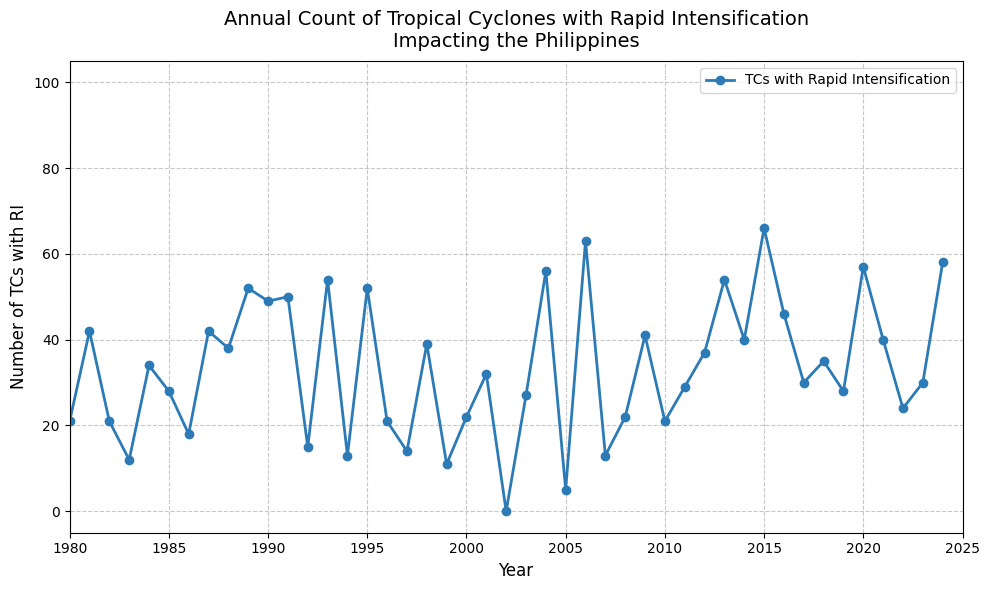

In [14]:
# Plot the annual counts
plt.figure(figsize=(10, 6))
plt.plot(annual_ri_counts['year'], annual_ri_counts['ri_count'], marker='o',linestyle='-', color='#2c7bb6',
         markersize=6, linewidth=2, label="TCs with Rapid Intensification")
plt.title('Annual Count of Tropical Cyclones with Rapid Intensification\nImpacting the Philippines',fontsize=14, pad=10)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of TCs with RI', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(1980, 2025)
plt.legend()
plt.tight_layout()
plt.show()


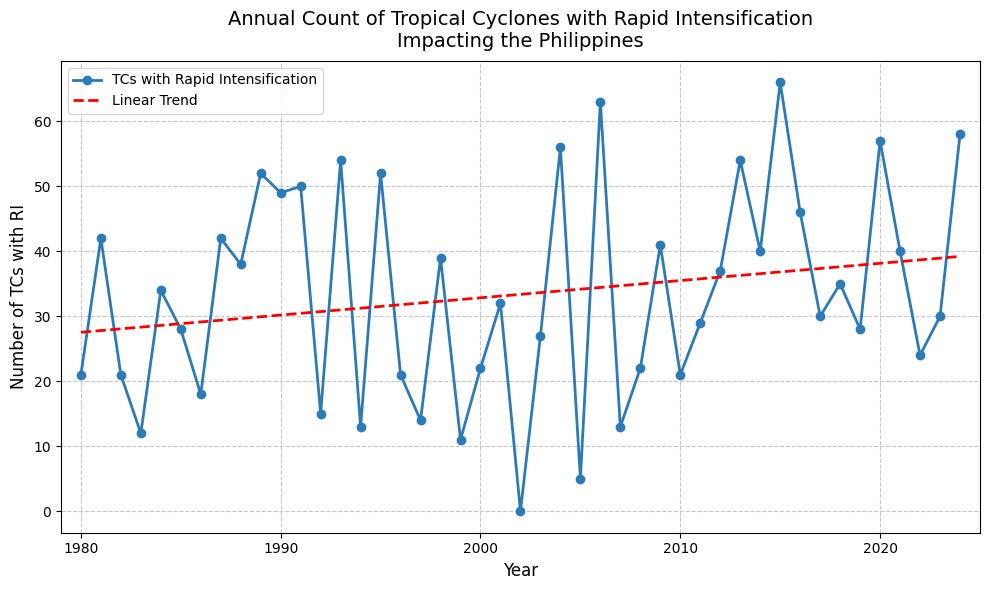

In [15]:
# Plot the annual counts as a line plot with trend line for 1980–2024
annual_ri_counts_plot = annual_ri_counts[annual_ri_counts['year'].between(1980, 2024)]
plt.figure(figsize=(10, 6))
plt.plot(annual_ri_counts_plot['year'], annual_ri_counts_plot['ri_count'],
         marker='o', linestyle='-', color='#2c7bb6', markersize=6, linewidth=2,
         label="TCs with Rapid Intensification")
# Calculate linear trend
z = np.polyfit(annual_ri_counts_plot['year'], annual_ri_counts_plot['ri_count'], 1)
p = np.poly1d(z)
plt.plot(annual_ri_counts_plot['year'], p(annual_ri_counts_plot['year']),
         color='red', linestyle='--', linewidth=2, label='Linear Trend')
plt.title('Annual Count of Tropical Cyclones with Rapid Intensification\nImpacting the Philippines',
         fontsize=14, pad=10)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of TCs with RI', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(1979, 2025)
plt.legend()
plt.tight_layout()
plt.show()


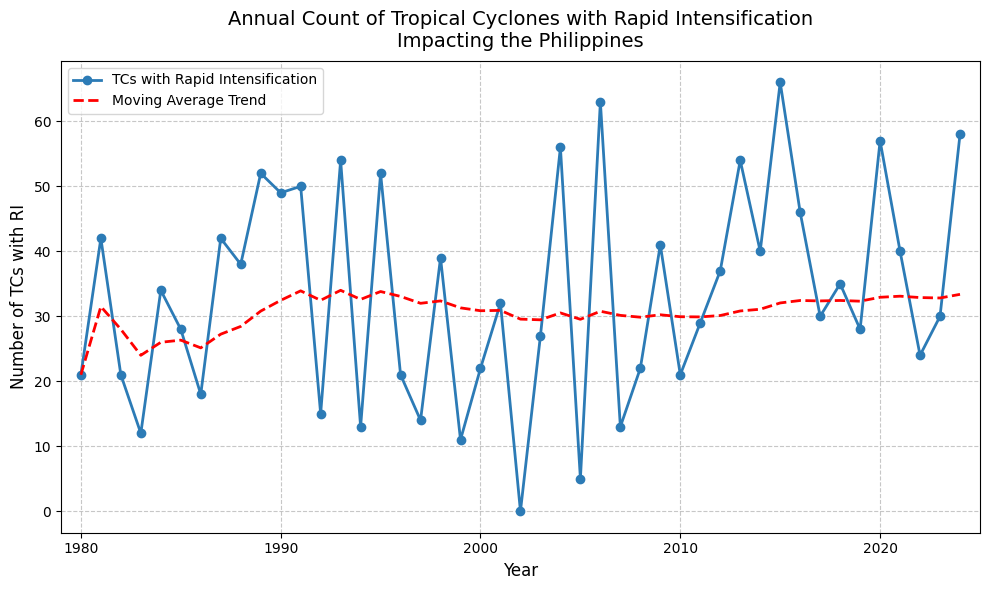

In [16]:
# Plot the annual counts as a line plot with moving average trend for 1980–2024
annual_ri_counts_plot = annual_ri_counts[annual_ri_counts['year'].between(1980, 2024)]
plt.figure(figsize=(10, 6))
plt.plot(annual_ri_counts_plot['year'], annual_ri_counts_plot['ri_count'],
         marker='o', linestyle='-', color='#2c7bb6', markersize=6, linewidth=2,
         label="TCs with Rapid Intensification")
# Calculate cumulative moving average trend
moving_avg = annual_ri_counts_plot['ri_count'].expanding().mean()
plt.plot(annual_ri_counts_plot['year'], moving_avg,
         color='red', linestyle='--', linewidth=2, label='Moving Average Trend')
plt.title('Annual Count of Tropical Cyclones with Rapid Intensification\nImpacting the Philippines',
         fontsize=14, pad=10)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of TCs with RI', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(1979, 2025)
plt.legend()
plt.tight_layout()
plt.show()


# **Bar Chart of Annual Count of Tropical Cyclones with Rapid Intensification Impacting the Philippines**

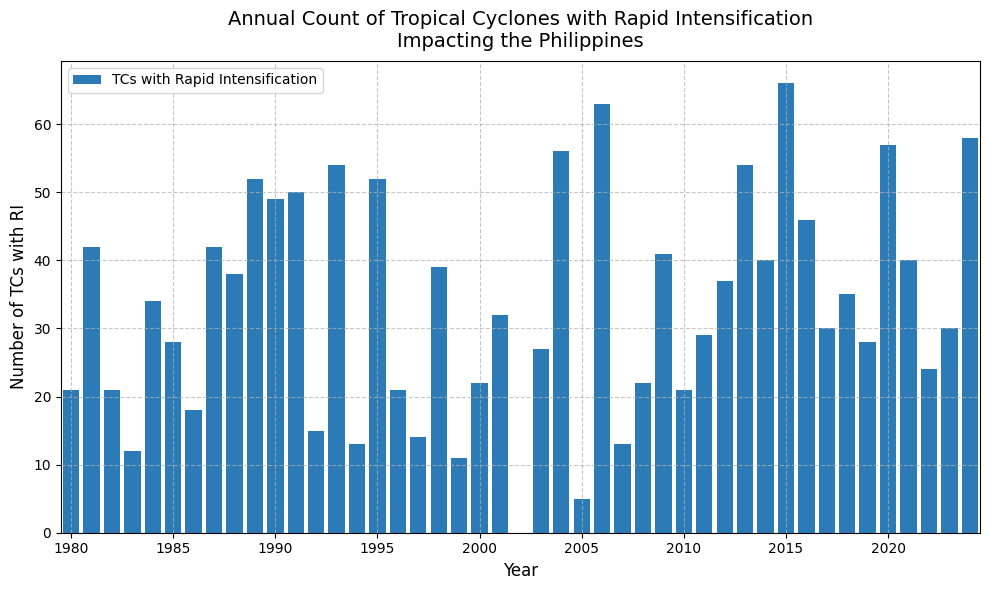

In [17]:
# Plot the annual counts as a bar chart for 1980–2024
annual_ri_counts_plot = annual_ri_counts[annual_ri_counts['year'].between(1980, 2024)]
plt.figure(figsize=(10, 6))
plt.bar(annual_ri_counts_plot['year'], annual_ri_counts_plot['ri_count'],
        color='#2c7bb6', width=0.8, label="TCs with Rapid Intensification")
plt.title('Annual Count of Tropical Cyclones with Rapid Intensification\nImpacting the Philippines',
         fontsize=14, pad=10)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of TCs with RI', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(1979.5, 2024.5)  # Adjust for bar alignment
plt.legend()
plt.tight_layout()
plt.show()


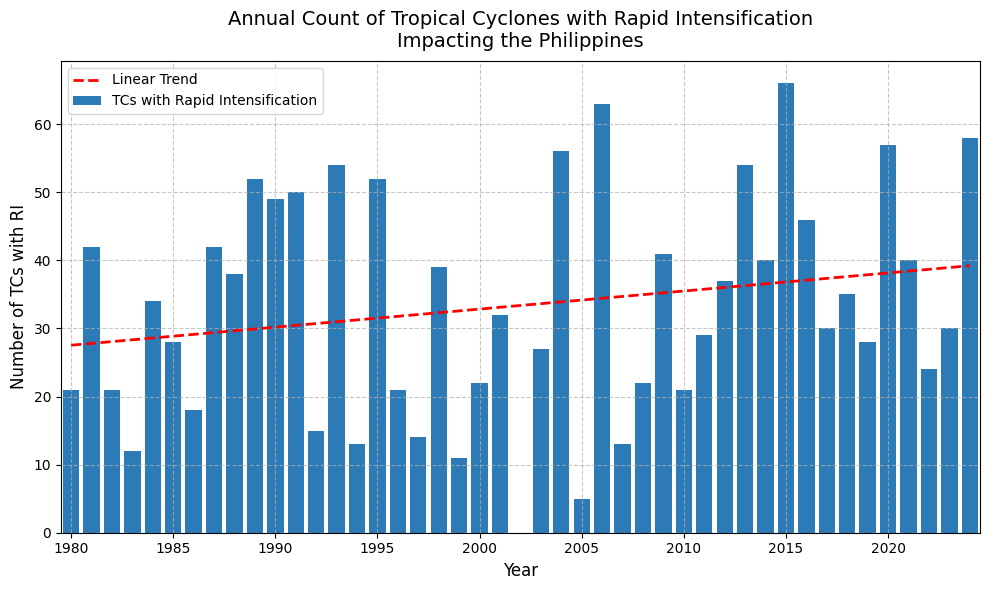

In [18]:
# Plot the annual counts as a bar chart with trend line for 1980–2024
annual_ri_counts_plot = annual_ri_counts[annual_ri_counts['year'].between(1980, 2024)]
plt.figure(figsize=(10, 6))
plt.bar(annual_ri_counts_plot['year'], annual_ri_counts_plot['ri_count'],
        color='#2c7bb6', width=0.8, label="TCs with Rapid Intensification")
# Calculate linear trend
z = np.polyfit(annual_ri_counts_plot['year'], annual_ri_counts_plot['ri_count'], 1)
p = np.poly1d(z)
plt.plot(annual_ri_counts_plot['year'], p(annual_ri_counts_plot['year']),
         color='red', linestyle='--', linewidth=2, label='Linear Trend')
plt.title('Annual Count of Tropical Cyclones with Rapid Intensification\nImpacting the Philippines',
         fontsize=14, pad=10)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of TCs with RI', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(1979.5, 2024.5)  # Adjust for bar alignment
plt.legend()
plt.tight_layout()
plt.show()


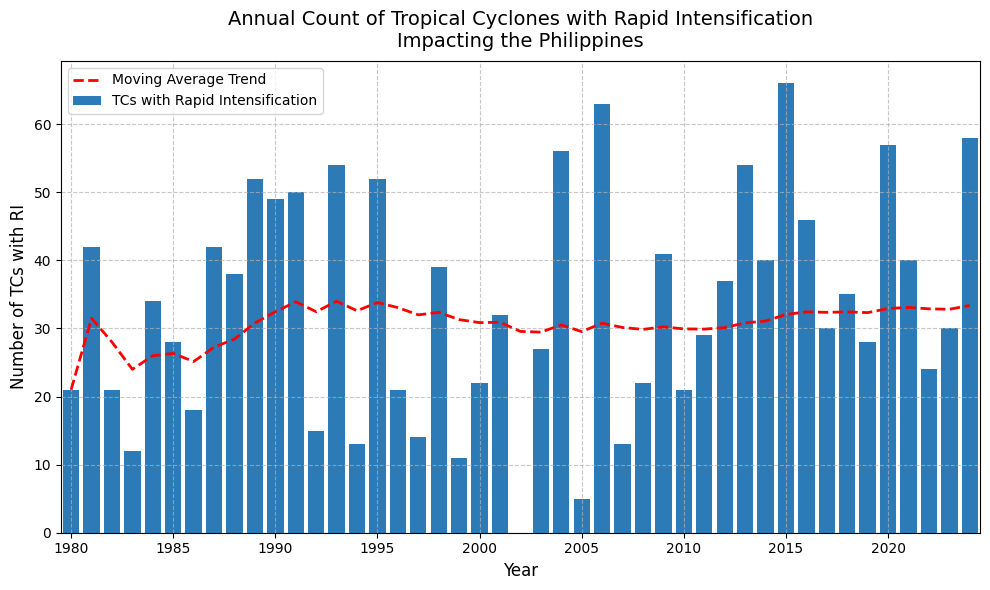

In [19]:
# Plot the annual counts as a bar chart with Moving Average Trend for 1980–2024
annual_ri_counts_plot = annual_ri_counts[annual_ri_counts['year'].between(1980, 2024)]
plt.figure(figsize=(10, 6))
plt.bar(annual_ri_counts_plot['year'], annual_ri_counts_plot['ri_count'],
        color='#2c7bb6', width=0.8, label="TCs with Rapid Intensification")
# Calculate Moving Average
moving_average = annual_ri_counts_plot['ri_count'].cumsum() / (annual_ri_counts_plot.index - annual_ri_counts_plot.index[0] + 1)
plt.plot(annual_ri_counts_plot['year'], moving_average,
         color='red', linestyle='--', linewidth=2, label='Moving Average Trend')
plt.title('Annual Count of Tropical Cyclones with Rapid Intensification\nImpacting the Philippines',
         fontsize=14, pad=10)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of TCs with RI', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(1979.5, 2024.5)  # Adjust for bar alignment
plt.legend()
plt.tight_layout()
plt.show()


# **Mean Annual Tropical Cyclones with Rapid Intensification impacting the Philippines (1980–2024)**

In [20]:
max_year = ibtracs_points['ISO_TIME'].dt.year.max()
five_year_bins = list(range(1980, max_year + 1, 5)) + [max_year + 1]
five_year_labels = [f"{start}–{min(start + 4, max_year)}" for start in five_year_bins[:-1]]
annual_ri_counts_1980 = annual_ri_counts[annual_ri_counts['year'] >= 1980].copy()
annual_ri_counts_1980['period'] = pd.cut(annual_ri_counts_1980['year'],
                                         bins=five_year_bins,
                                         labels=five_year_labels, # Assigns labels ["1980–1984", "1985–1989", ..., "2015–2019","2020-2024"] to the intervals
                                         include_lowest=True, # Ensures the lowest value is included
                                         right=False) # Makes intervals left-inclusive
five_year_means = annual_ri_counts_1980.groupby('period')['ri_count'].mean().reset_index()
five_year_means['ri_count'] = five_year_means['ri_count'].round(2)


<ipython-input-20-3594250465>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  five_year_means = annual_ri_counts_1980.groupby('period')['ri_count'].mean().reset_index()


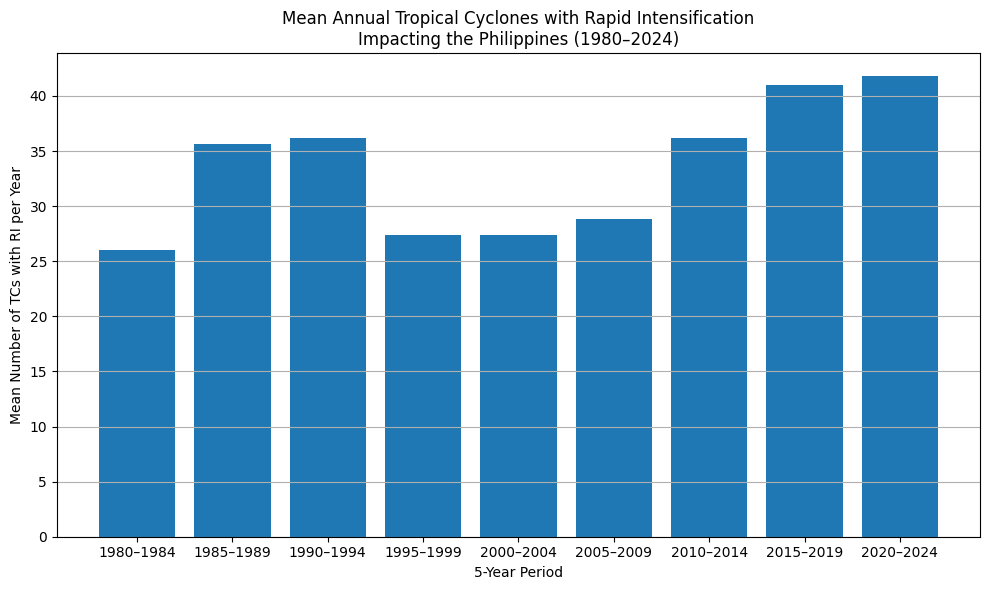

In [21]:
plt.figure(figsize=(10, 6))
plt.bar(five_year_means['period'], five_year_means['ri_count'])
plt.title('Mean Annual Tropical Cyclones with Rapid Intensification\nImpacting the Philippines (1980–2024)')
plt.xlabel('5-Year Period')
plt.ylabel('Mean Number of TCs with RI per Year')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# **Monthly Distribution of RI Events by 5-Year Period**

<ipython-input-22-2269917651>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_counts = ri_df.groupby(['period', 'month']).size().unstack(fill_value=0)


<Figure size 1200x600 with 0 Axes>

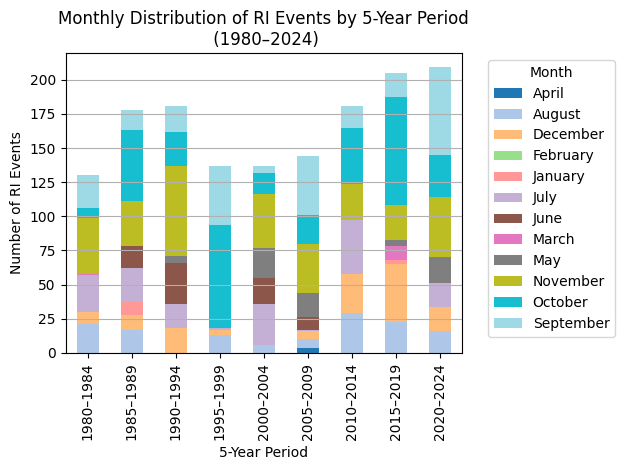

In [22]:
# Add month to ri_df
ri_df['month'] = ri_df['start_time'].dt.month_name()
# Group by 5-year period and month
ri_df['period'] = pd.cut(ri_df['year'], bins=five_year_bins, labels=five_year_labels, include_lowest=True, right=False)
monthly_counts = ri_df.groupby(['period', 'month']).size().unstack(fill_value=0)
# Plot stacked bar chart
plt.figure(figsize=(12, 6))
monthly_counts.plot(kind='bar', stacked=True, colormap='tab20')
plt.title(f'Monthly Distribution of RI Events by 5-Year Period\n (1980–{max_year})')
plt.xlabel('5-Year Period')
plt.ylabel('Number of RI Events')
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


<ipython-input-23-1773485995>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_counts = ri_df.groupby(['month', 'period']).size().unstack(fill_value=0)


<Figure size 1200x600 with 0 Axes>

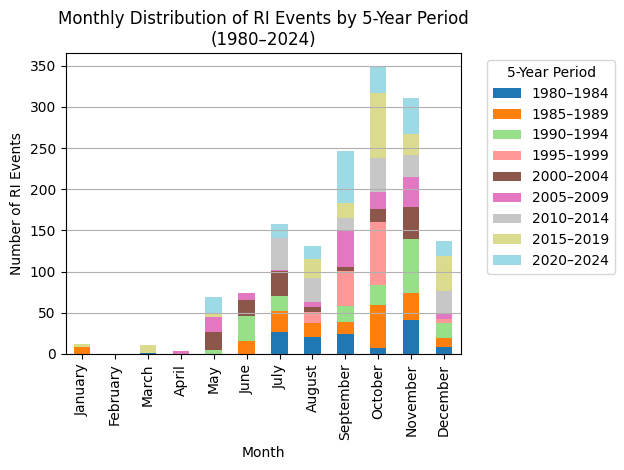

In [23]:
# Add month to ri_df
ri_df['month'] = ri_df['start_time'].dt.month_name()
# Define ordered months
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
ri_df['month'] = pd.Categorical(ri_df['month'], categories=month_order, ordered=True)
# Group by month and 5-year period
ri_df['period'] = pd.cut(ri_df['year'], bins=five_year_bins, labels=five_year_labels, include_lowest=True, right=False)
monthly_counts = ri_df.groupby(['month', 'period']).size().unstack(fill_value=0)
# Plot stacked bar chart
plt.figure(figsize=(12, 6))
monthly_counts.plot(kind='bar', stacked=True, colormap='tab20')
plt.title(f'Monthly Distribution of RI Events by 5-Year Period\n(1980–{max_year})')
plt.xlabel('Month')
plt.ylabel('Number of RI Events')
plt.legend(title='5-Year Period', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


<ipython-input-24-661885233>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_counts = ri_df.groupby(['period', 'month']).size().unstack(fill_value=0)


<Figure size 1200x600 with 0 Axes>

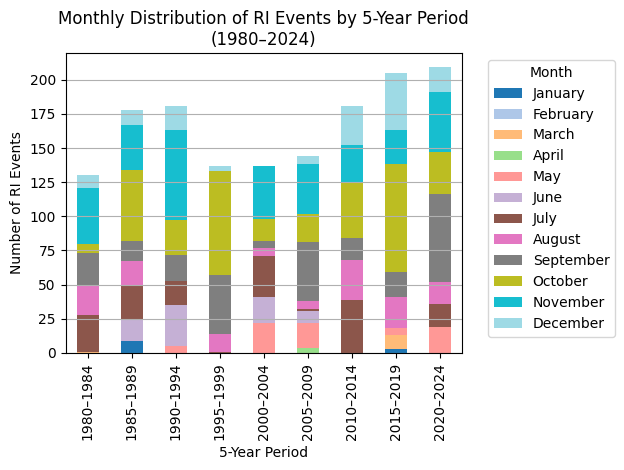

In [24]:
# Add month to ri_df
ri_df['month'] = ri_df['start_time'].dt.month_name()
# Define ordered months (January at bottom, December at top)
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
ri_df['month'] = pd.Categorical(ri_df['month'], categories=month_order, ordered=True)
# Group by 5-year period and month
ri_df['period'] = pd.cut(ri_df['year'], bins=five_year_bins, labels=five_year_labels, include_lowest=True, right=False)
monthly_counts = ri_df.groupby(['period', 'month']).size().unstack(fill_value=0)
# Ensure month columns are in correct order
monthly_counts = monthly_counts[month_order]
# Plot stacked bar chart
plt.figure(figsize=(12, 6))
monthly_counts.plot(kind='bar', stacked=True, colormap='tab20')
plt.title(f'Monthly Distribution of RI Events by 5-Year Period\n(1980–{max_year})')
plt.xlabel('5-Year Period')
plt.ylabel('Number of RI Events')
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


<ipython-input-25-43217334>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_counts = ri_df.groupby(['period', 'month']).size().unstack(fill_value=0)


<Figure size 1200x600 with 0 Axes>

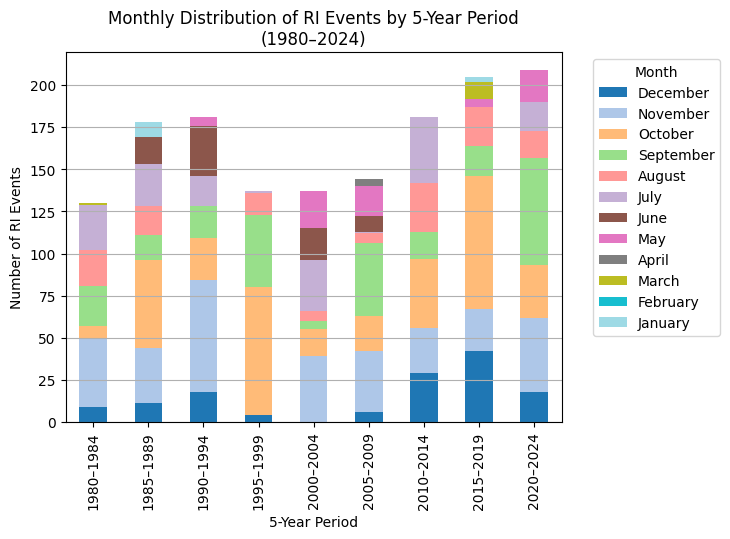

In [25]:
# Add month to ri_df
ri_df['month'] = ri_df['start_time'].dt.month_name()
# Define ordered months (January at top, December at bottom)
month_order = ['December', 'November', 'October', 'September', 'August', 'July',
               'June', 'May', 'April', 'March', 'February', 'January']
ri_df['month'] = pd.Categorical(ri_df['month'], categories=month_order, ordered=True)
# Group by 5-year period and month
ri_df['period'] = pd.cut(ri_df['year'], bins=five_year_bins, labels=five_year_labels, include_lowest=True, right=False)
monthly_counts = ri_df.groupby(['period', 'month']).size().unstack(fill_value=0)
# Ensure month columns are in correct order (December to January for top-to-bottom stacking)
monthly_counts = monthly_counts[month_order]
# Plot stacked bar chart
plt.figure(figsize=(12, 6))
monthly_counts.plot(kind='bar', stacked=True, colormap='tab20')
plt.title(f'Monthly Distribution of RI Events by 5-Year Period\n(1980–{max_year})')
plt.xlabel('5-Year Period')
plt.ylabel('Number of RI Events')
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y')
plt.show()


# **Heatmap of RI Events by Year and Hour of Day in Philippines Standard Time**

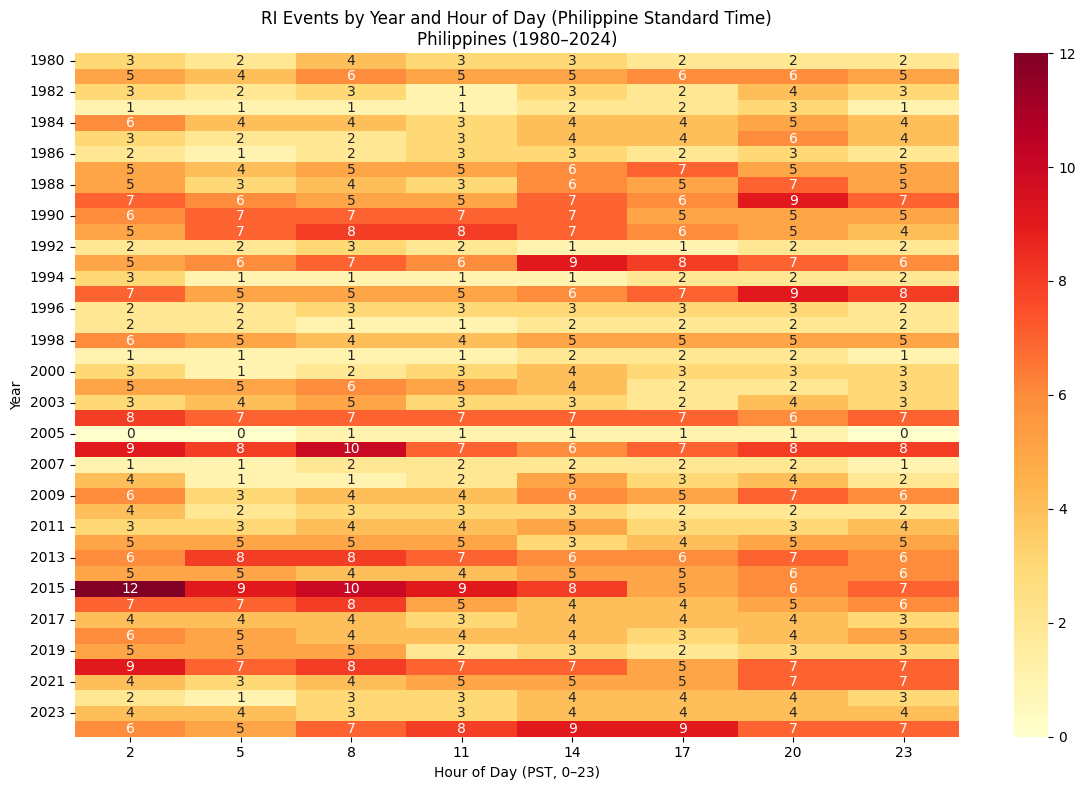

In [26]:
import seaborn as sns
if not ri_df.empty:
    # Convert start_time from UTC to PST (UTC+8)
    ri_df['start_time_pst'] = ri_df['start_time'] + timedelta(hours=8)
    # Extract hour and filter years
    ri_df['hour'] = ri_df['start_time_pst'].dt.hour
    ri_df_1980 = ri_df[ri_df['year'] >= 1980].copy()
    # Pivot table for heatmap
    heatmap_data = ri_df_1980.pivot_table(index='year', columns='hour', values='SID', aggfunc='count', fill_value=0)
    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt='.0f')
    plt.title(f'RI Events by Year and Hour of Day (Philippine Standard Time)\nPhilippines (1980–{max_year})')
    plt.xlabel('Hour of Day (PST, 0–23)')
    plt.ylabel('Year')
    plt.tight_layout()
    plt.show()
else:
    print("No RI events for heatmap; skipping plot.")


# **Heatmap of Mean Annual RI Events by 5-Year Period and Hour of Day in Philippine Standard Time**

<ipython-input-27-3405251214>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  period_hour_counts = ri_df_1980.groupby(['period', 'hour']).size().reset_index(name='count')
<ipython-input-27-3405251214>:13: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data_period = period_hour_counts.pivot_table(index='period', columns='hour', values='mean_count', fill_value=0)


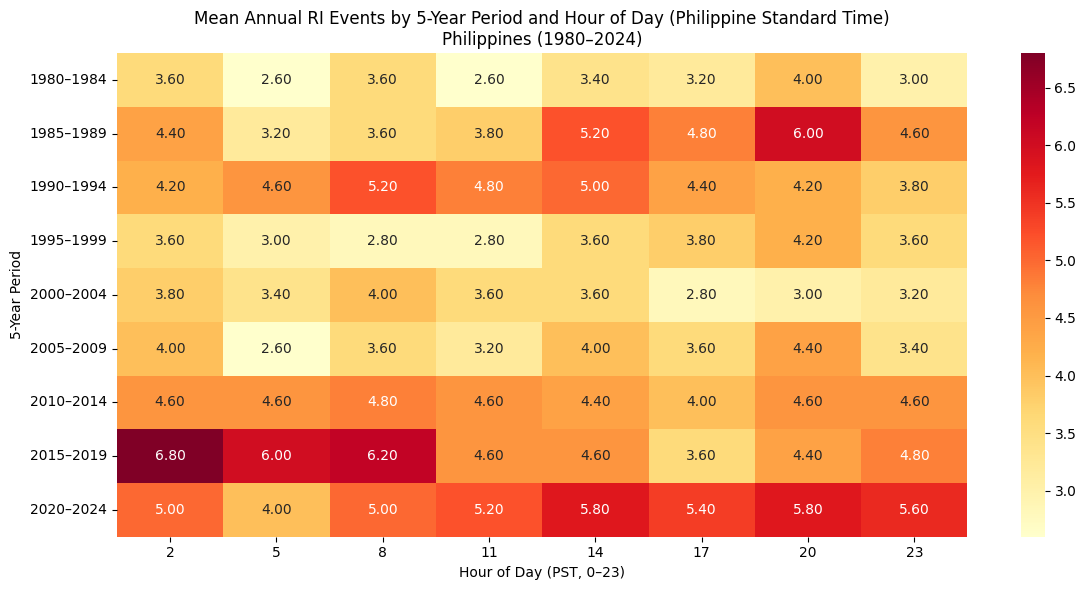

In [27]:
if not ri_df.empty:
    # Use existing PST time and hour
    ri_df_1980['period'] = pd.cut(ri_df_1980['year'],
                                  bins=five_year_bins,
                                  labels=five_year_labels,
                                  include_lowest=True,
                                  right=False)
    # Count RI events by period and hour
    period_hour_counts = ri_df_1980.groupby(['period', 'hour']).size().reset_index(name='count')
    # Calculate mean per year (divide by 5 years per period)
    period_hour_counts['mean_count'] = period_hour_counts['count'] / 5
    # Pivot table for heatmap
    heatmap_data_period = period_hour_counts.pivot_table(index='period', columns='hour', values='mean_count', fill_value=0)
    # Plot heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(heatmap_data_period, cmap='YlOrRd', annot=True, fmt='.2f')
    plt.title(f'Mean Annual RI Events by 5-Year Period and Hour of Day (Philippine Standard Time)\nPhilippines (1980–{max_year})')
    plt.xlabel('Hour of Day (PST, 0–23)')
    plt.ylabel('5-Year Period')
    plt.tight_layout()
    plt.show()
else:
    print("No RI events for period mean heatmap; skipping plot.")


# **Box Plot of Wind Speed Increases During RI Events**

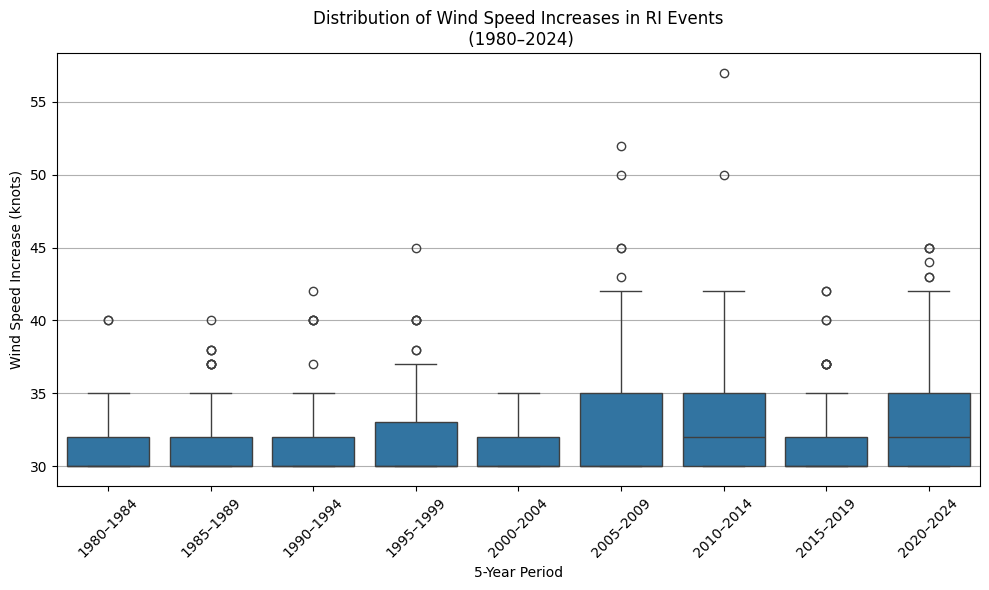

In [28]:
# Add 5-year period to ri_df
ri_df['period'] = pd.cut(ri_df['year'], bins=five_year_bins, labels=five_year_labels, include_lowest=True, right=False)
# Plot box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='period', y='wind_increase', data=ri_df)
plt.title(f'Distribution of Wind Speed Increases in RI Events\n (1980–{max_year})')
plt.xlabel('5-Year Period')
plt.ylabel('Wind Speed Increase (knots)')
plt.grid(True, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# **Scatter Plot of RI Event Locations**

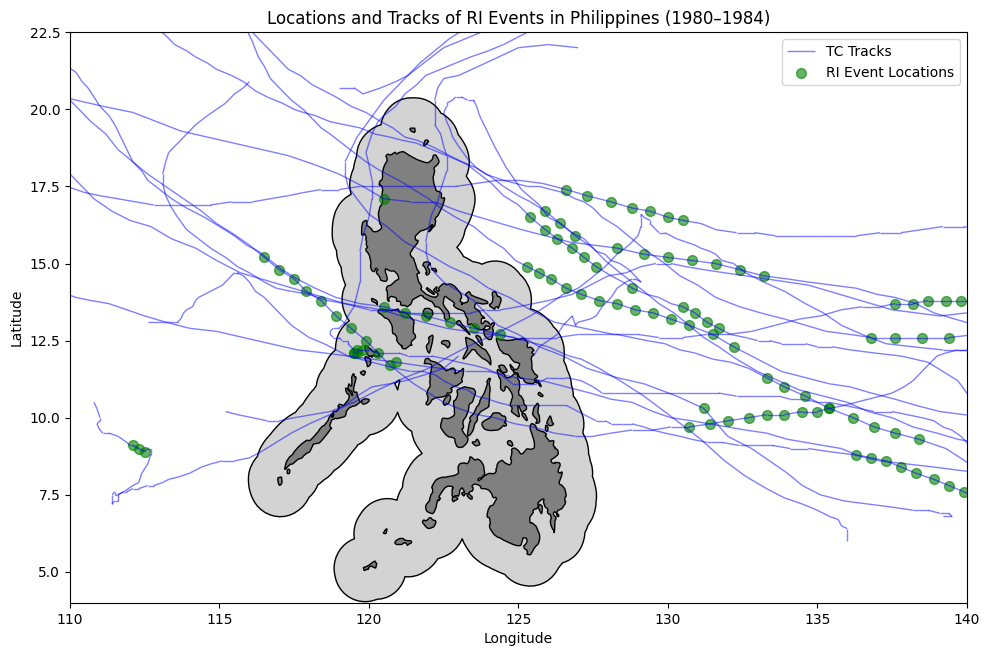

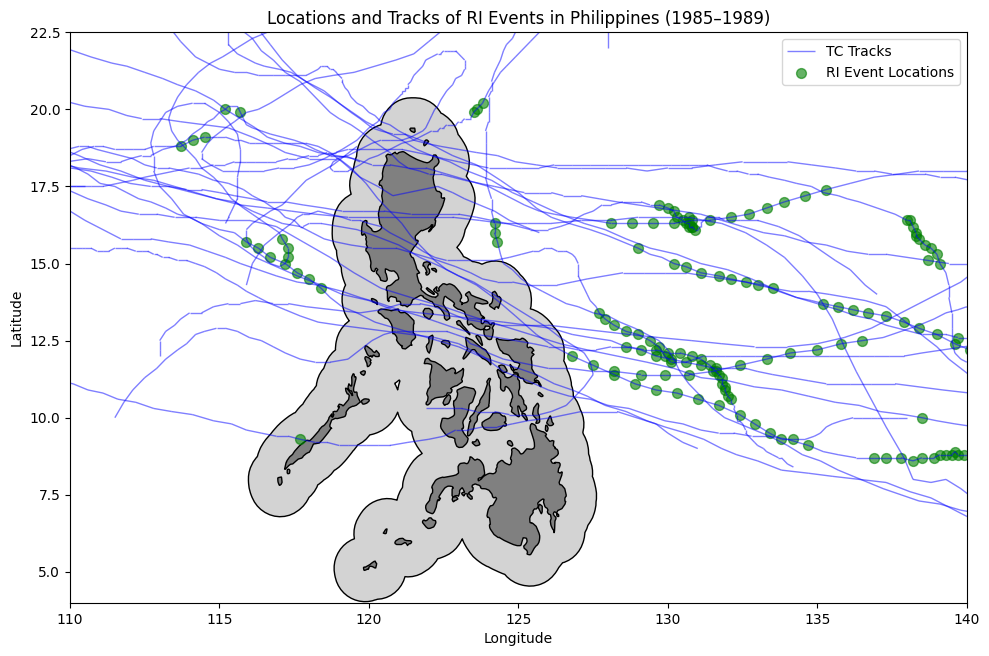

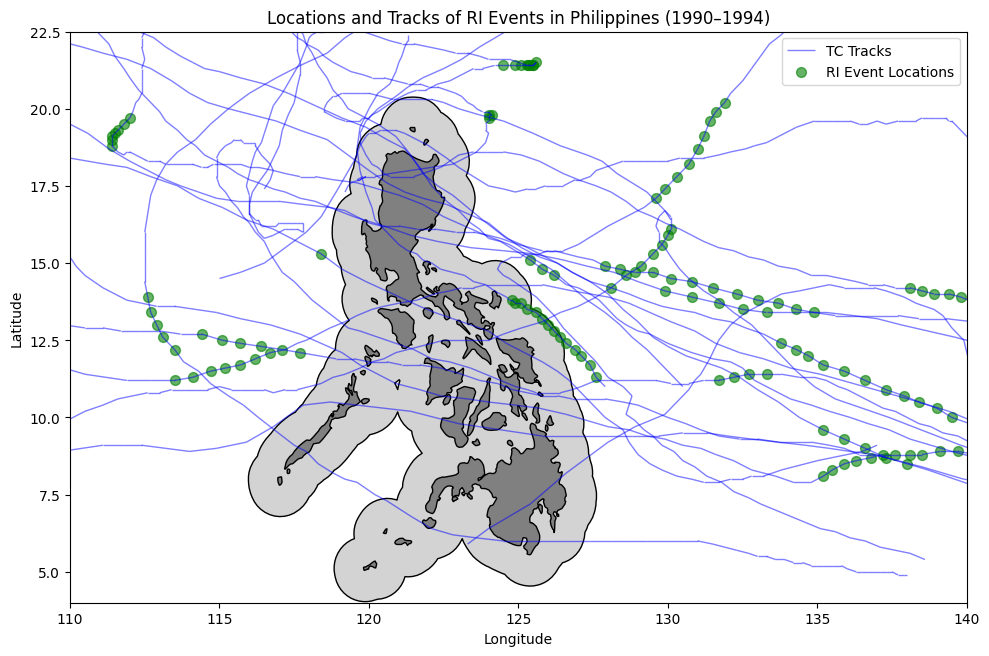

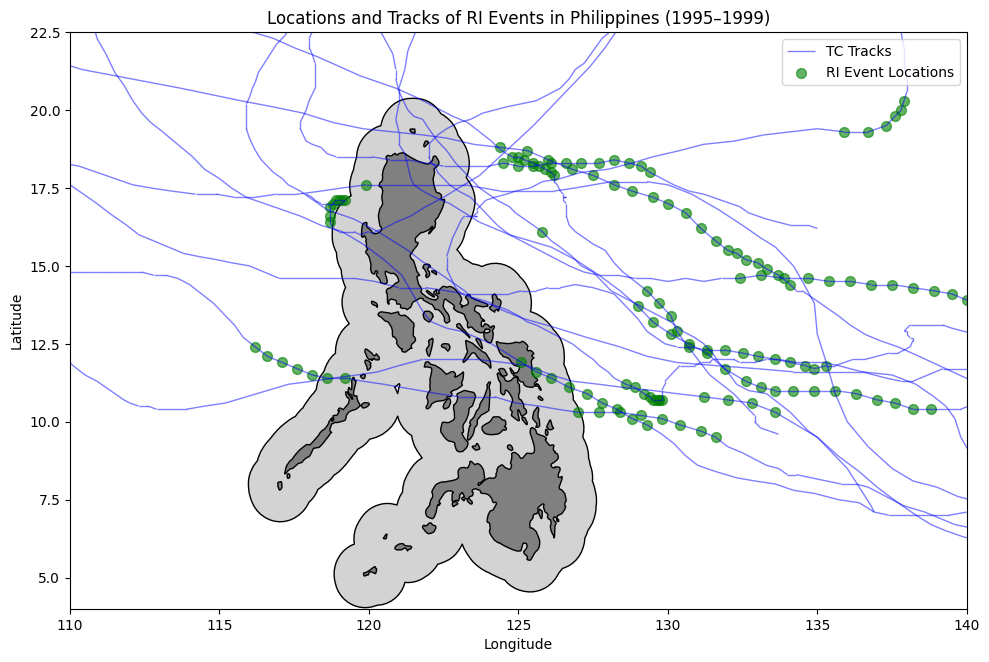

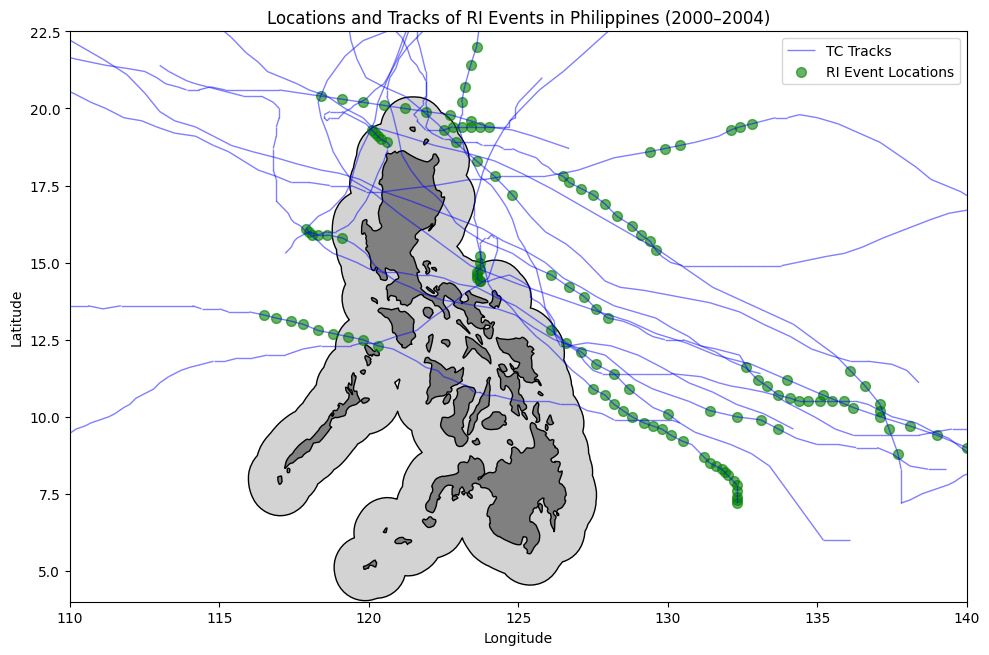

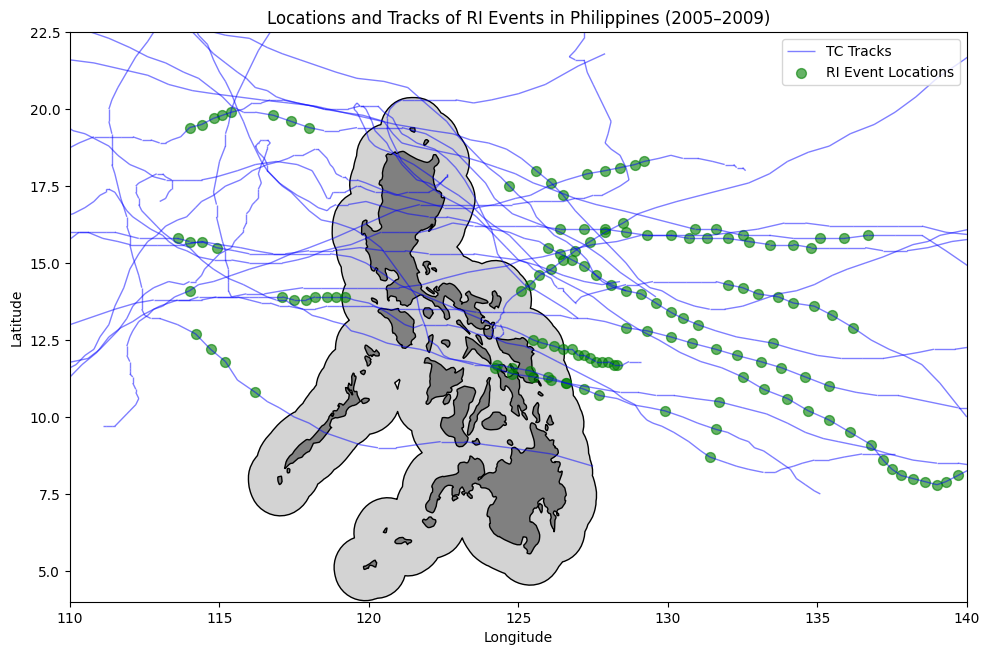

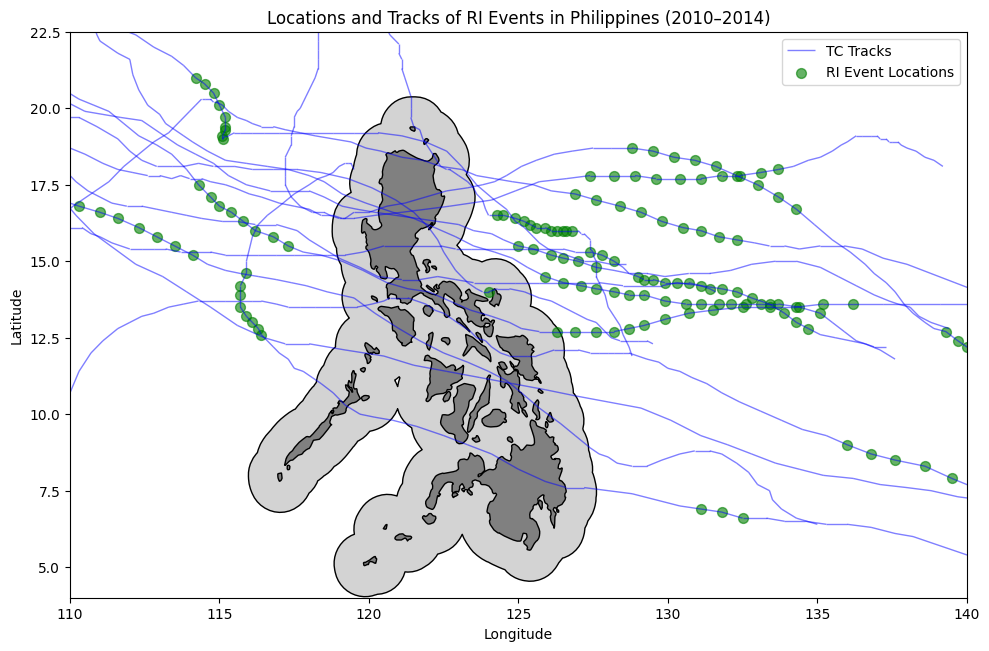

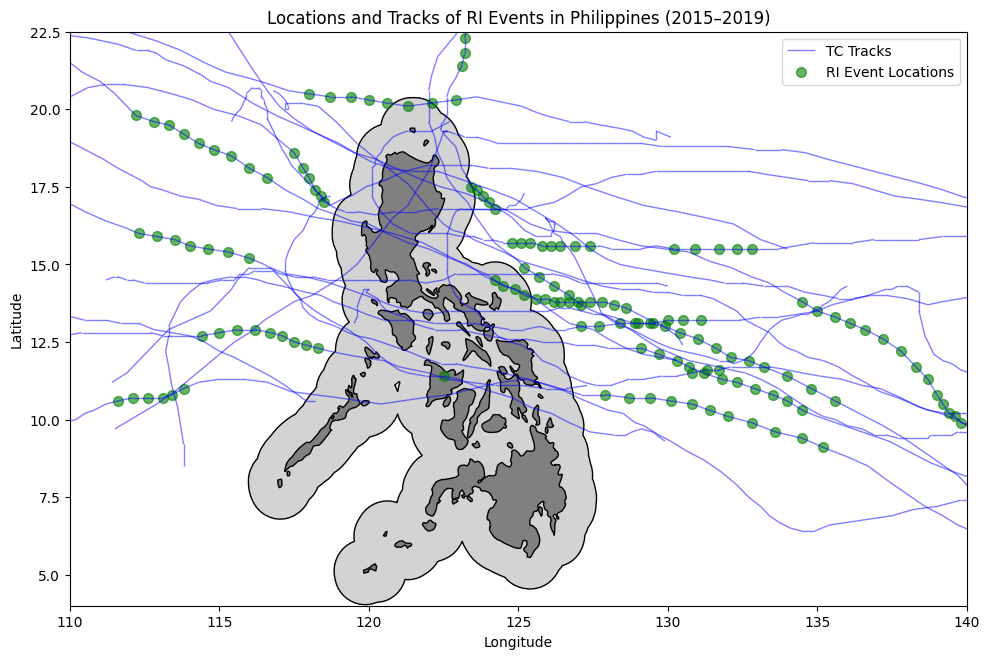

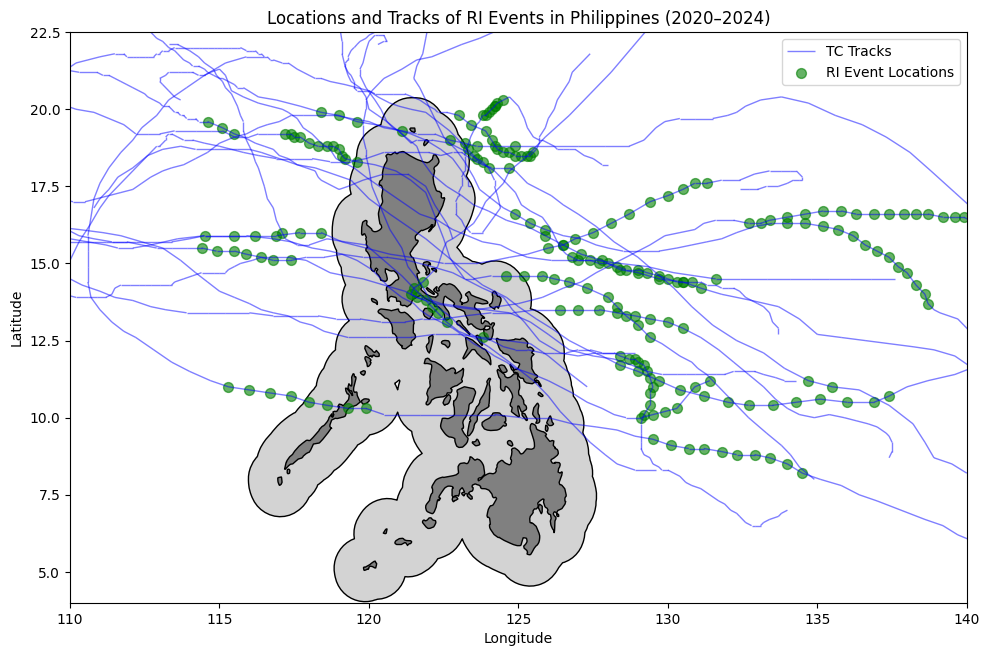

In [29]:
# Scatter Plots of RI Event Locations with Tracks by 5-Year Period (1980–max_year)
if not ri_df.empty:
    # Merge ri_df with gdf_philippines_storms to get geometry
    ri_locations = ri_df.merge(gdf_philippines_storms[['SID', 'ISO_TIME', 'geometry']],
                               left_on=['SID', 'start_time'], right_on=['SID', 'ISO_TIME'])
    ri_locations = gpd.GeoDataFrame(ri_locations, geometry='geometry')
    ri_locations['period'] = pd.cut(ri_locations['year'],
                                    bins=five_year_bins,
                                    labels=five_year_labels,
                                    include_lowest=True,
                                    right=False)
    # Filter to 1980–max_year
    ri_locations = ri_locations[ri_locations['year'] >= 1980]

    # Ensure lines CRS matches ri_locations
    if lines.crs != ri_locations.crs:
        lines = lines.to_crs(ri_locations.crs)

    # Create a scatter plot with tracks for each 5-year period
    for period in five_year_labels:
        period_data = ri_locations[ri_locations['period'] == period]
        if period_data.empty:
            print(f"No RI events for period {period}; skipping scatter plot.")
            continue
        # Filter lines to SIDs in this period
        period_sids = period_data['SID'].unique()
        period_lines = lines[lines['SID'].isin(period_sids)]
        fig, ax = plt.subplots(figsize=(10, 8))
        # Plot buffer as background
        buffer_gdf.plot(ax=ax, color='lightgray', edgecolor='black')
        phl_land.plot(ax=ax, color='gray' , edgecolor='black')
        # Plot TC tracks
        if not period_lines.empty:
            period_lines.plot(ax=ax, color='blue', linewidth=1, alpha=0.5, label='TC Tracks')
        # Plot RI event locations
        period_data.plot(ax=ax, marker='o', color='green', markersize=50, alpha=0.6, label='RI Event Locations')
        plt.title(f'Locations and Tracks of RI Events in Philippines ({period})')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.xlim(110, 140)  # Set longitude range
        plt.ylim(4, 22.5)     # Set latitude range
        plt.legend()
        plt.tight_layout()
        # Generate safe filename from period (e.g., "1980–1984" → "1980_1984")
        period_filename = period.replace('–', '_')
        plt.show()
else:
    print("No RI events for scatter plots; skipping.")

In [30]:
max_year = ibtracs_points['ISO_TIME'].dt.year.max()
ten_year_bins = list(range(1980, max_year + 1, 10)) + [max_year + 1]
ten_year_labels = [f"{start}–{min(start + 9, max_year)}" for start in ten_year_bins[:-1]]
annual_ri_counts_1980 = annual_ri_counts[annual_ri_counts['year'] >= 1980].copy()
annual_ri_counts_1980['period'] = pd.cut(annual_ri_counts_1980['year'],
                                         bins=ten_year_bins,
                                         labels=ten_year_labels, # Assigns labels ["1980–1989", "1990–1999", ..., "2020-2024"] to the intervals
                                         include_lowest=True, # Ensures the lowest value is included
                                         right=False) # Makes intervals left-inclusive
ten_year_means = annual_ri_counts_1980.groupby('period')['ri_count'].mean().reset_index()
ten_year_means['ri_count'] = ten_year_means['ri_count'].round(2)


<ipython-input-30-815061463>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ten_year_means = annual_ri_counts_1980.groupby('period')['ri_count'].mean().reset_index()


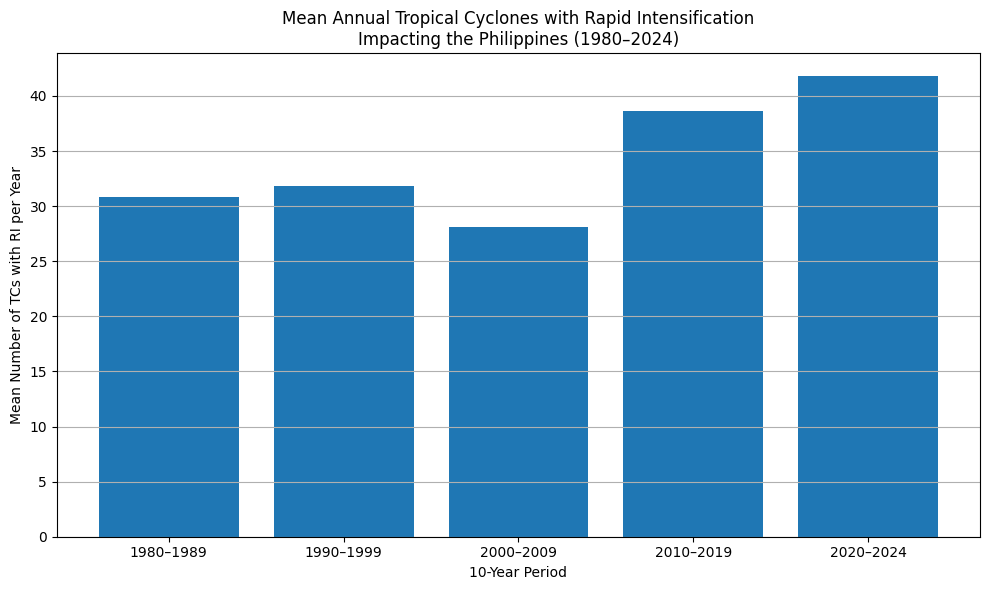

In [31]:
plt.figure(figsize=(10, 6))
plt.bar(ten_year_means['period'], ten_year_means['ri_count'])
plt.title('Mean Annual Tropical Cyclones with Rapid Intensification\nImpacting the Philippines (1980–2024)')
plt.xlabel('10-Year Period')
plt.ylabel('Mean Number of TCs with RI per Year')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

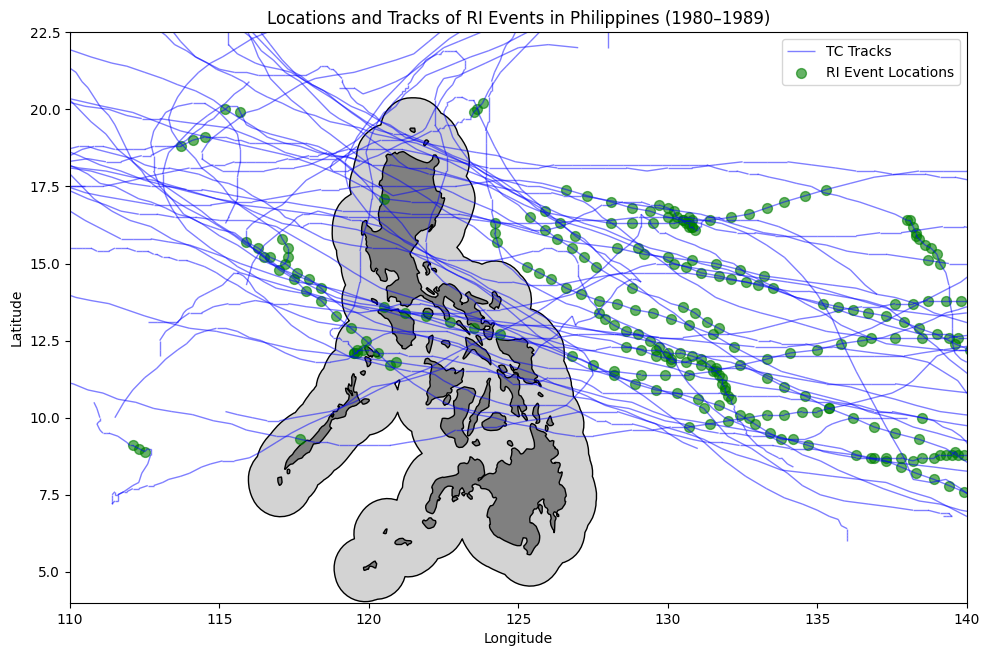

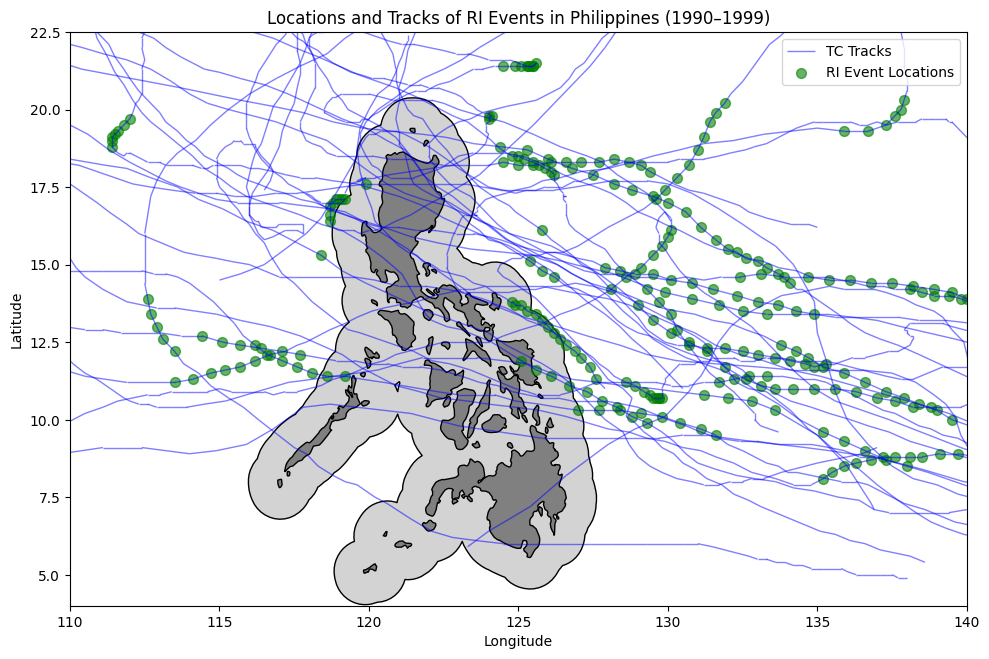

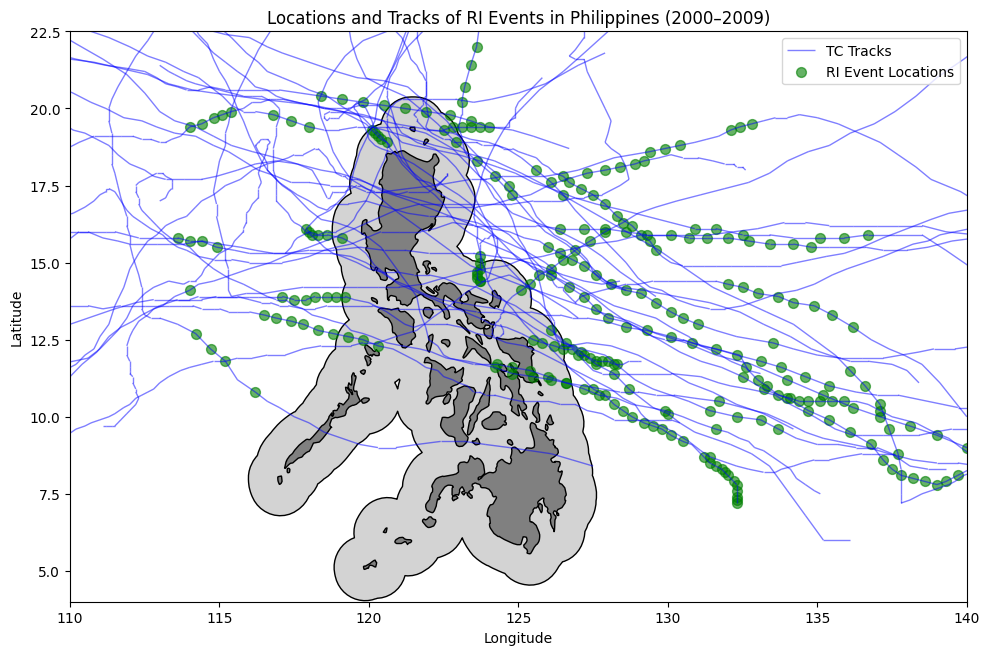

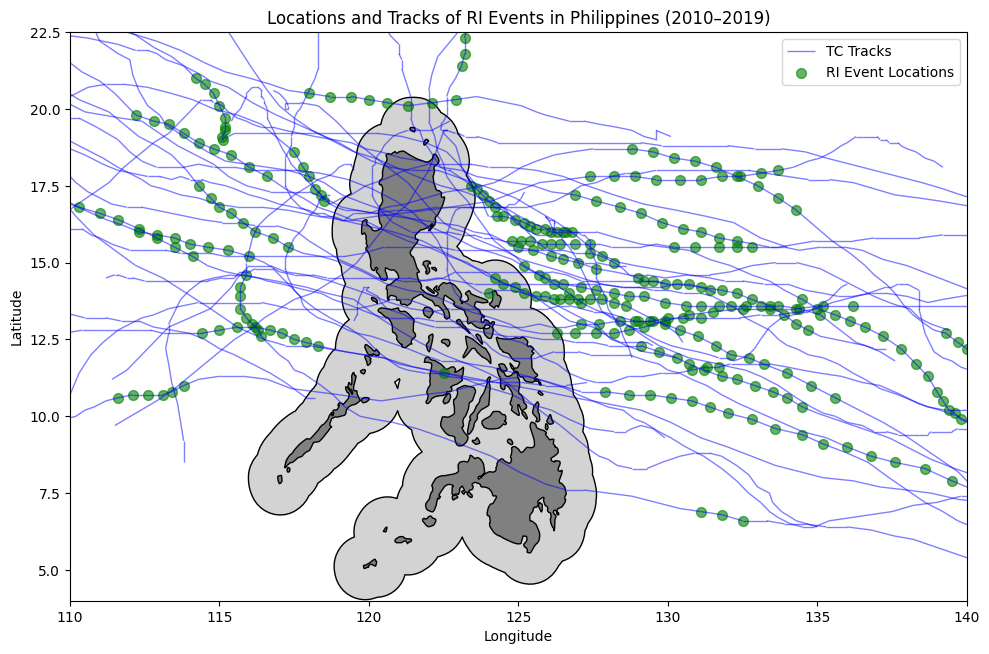

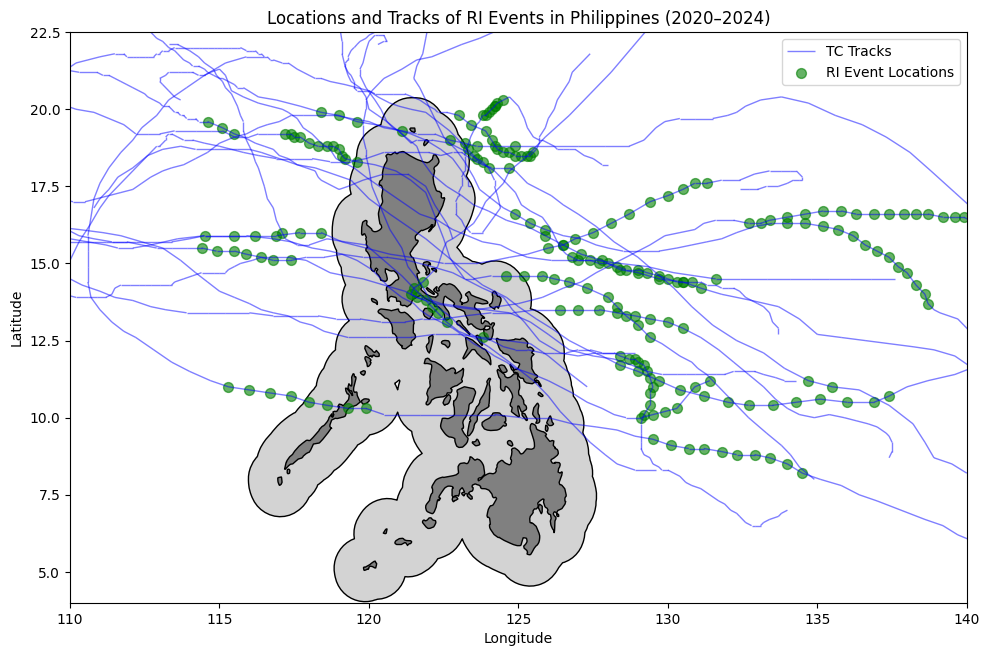

In [32]:
# Scatter Plots of RI Event Locations with Tracks by 10-Year Period (1980–max_year)
if not ri_df.empty:
    # Merge ri_df with gdf_philippines_storms to get geometry
    ri_locations = ri_df.merge(gdf_philippines_storms[['SID', 'ISO_TIME', 'geometry']],
                               left_on=['SID', 'start_time'], right_on=['SID', 'ISO_TIME'])
    ri_locations = gpd.GeoDataFrame(ri_locations, geometry='geometry')
    ri_locations['period'] = pd.cut(ri_locations['year'],
                                    bins=ten_year_bins,
                                    labels=ten_year_labels,
                                    include_lowest=True,
                                    right=False)
    # Filter to 1980–max_year
    ri_locations = ri_locations[ri_locations['year'] >= 1980]

    # Ensure lines CRS matches ri_locations
    if lines.crs != ri_locations.crs:
        lines = lines.to_crs(ri_locations.crs)

    # Create a scatter plot with tracks for each 10-year period
    for period in ten_year_labels:
        period_data = ri_locations[ri_locations['period'] == period]
        if period_data.empty:
            print(f"No RI events for period {period}; skipping scatter plot.")
            continue
        # Filter lines to SIDs in this period
        period_sids = period_data['SID'].unique()
        period_lines = lines[lines['SID'].isin(period_sids)]
        fig, ax = plt.subplots(figsize=(10, 8))
        # Plot buffer as background
        buffer_gdf.plot(ax=ax, color='lightgray', edgecolor='black')
        phl_land.plot(ax=ax, color='gray' , edgecolor='black')
        # Plot TC tracks
        if not period_lines.empty:
            period_lines.plot(ax=ax, color='blue', linewidth=1, alpha=0.5, label='TC Tracks')
        # Plot RI event locations
        period_data.plot(ax=ax, marker='o', color='green', markersize=50, alpha=0.6, label='RI Event Locations')
        plt.title(f'Locations and Tracks of RI Events in Philippines ({period})')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.xlim(110, 140)  # Set longitude range
        plt.ylim(4, 22.5)     # Set latitude range
        plt.legend()
        plt.tight_layout()
        plt.show()
else:
    print("No RI events for scatter plots; skipping.")

# **Line Plot of Cumulative RI Events**

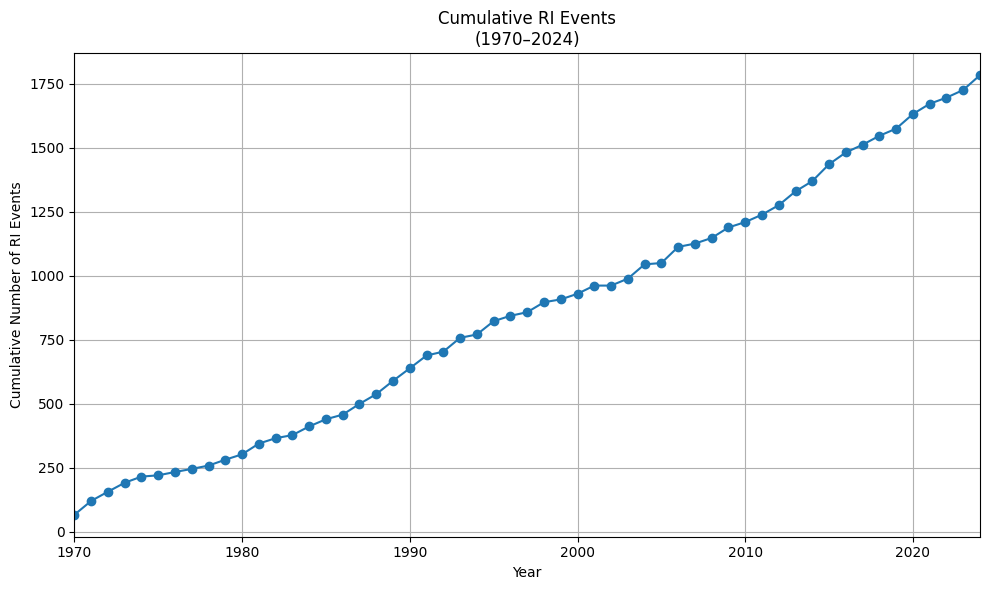

In [33]:
# Filter to 1970–2024 and calculate cumulative sum
cumulative_counts = annual_ri_counts[annual_ri_counts['year'].between(1970, 2024)].copy()
cumulative_counts['cumulative_ri'] = cumulative_counts['ri_count'].cumsum()
# Plot cumulative line
plt.figure(figsize=(10, 6))
plt.plot(cumulative_counts['year'], cumulative_counts['cumulative_ri'], marker='o')
plt.title('Cumulative RI Events\n(1970–2024)')
plt.xlabel('Year')
plt.ylabel('Cumulative Number of RI Events')
plt.grid(True)
plt.xlim(1970, 2024)
plt.tight_layout()
plt.show()
